In [1]:
import os
import sys
os.environ["THEANO_FLAGS"] = "device=cpu"
sys.path.append(os.getcwd()+"/..")
import lasagne
import theano.tensor as T
import theano
from tasks import check
from scripts import manifold

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
v = check(what="notebook", 
          #filename="..//model.pkl", 
          filename="../training/reproduce_bengio_denoising/fonts/model.pkl",
          dataset="fonts",
          force_w=28,
          force_h=28)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...
/home/mcherti/work/code/external/Lasagne/lasagne/layers/helper.py:212: UserWarning: get_output() was called with unused kwargs:
	determnistic (perhaps you meant deterministic)
  % "\n\t".join(suggestions))


{'seed': 2}


In [3]:
capsule, data, layers, w, h, c = v
print(w, h, c)
print(layers.keys())

(28, 28, 1)
['input', 'hid', 'hid_sparse', 'pre_output', 'output']


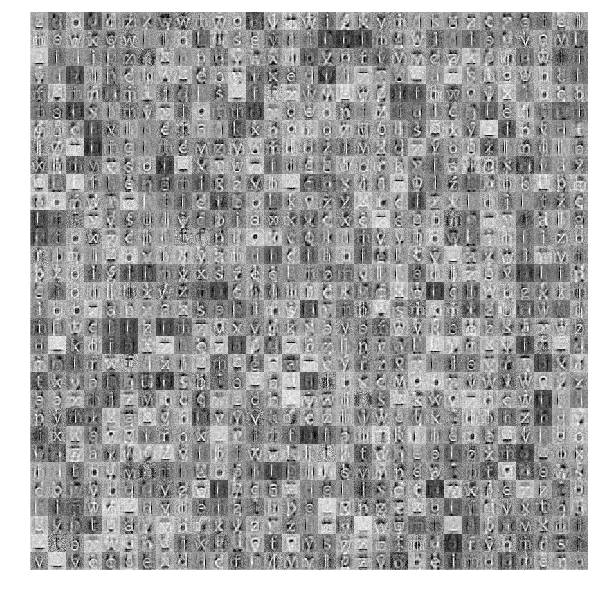

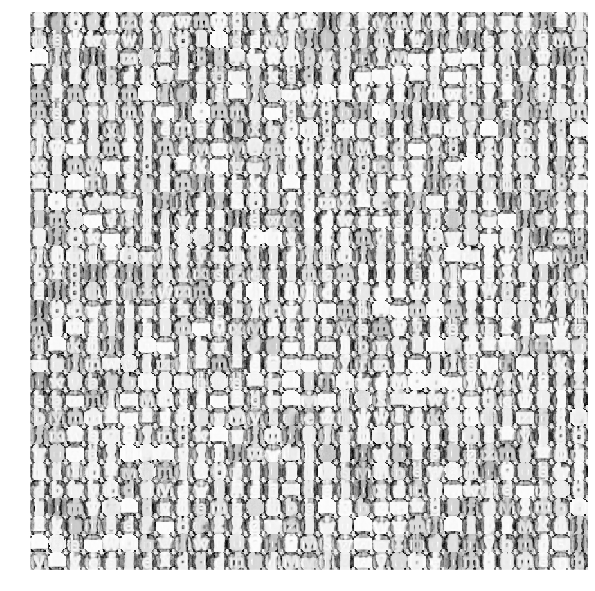

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
for name, layer in layers.items():
    #print(name, layer.output_shape)
    #if hasattr(layer, "W"):
    #    print(layer.W.get_value().shape)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2:
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            a, b = w, h
        else:
            W = W.reshape((W.shape[0]*W.shape[1], W.shape[2], W.shape[3]))
            a, b = W.shape[1:]
        fig = plt.figure(figsize=(10, 10))
        s = int(np.sqrt(W.shape[0]))
        plt.axis('off')
        img=tile_raster_images(W, (a, b), (s, s))
        plt.imshow(img, cmap="gray", interpolation='none')
        plt.show()

In [5]:
hid_nonlinearity = 'sigmoid'
out_nonlinearity = 'sigmoid'

def get_deriv(func, x, direct=False):
    if func == 'sigmoid':
        if direct:
            x_ = x
        else:
            x_ = T.nnet.sigmoid(x)
        return x_ * (1 - x_)
    elif func == 'tanh':
        if direct:
            x_  = x
        else:
            x_ = T.tanh(x)
        return 1 - x_ **2

In [7]:
X = T.tensor4()

Xrec = lasagne.layers.get_output(layers['output'], X)
Xrec = Xrec.reshape((Xrec.shape[0], -1))

xflat = X.reshape((X.shape[0], -1))
W = layers['hid'].W#p, h
R = layers['pre_output'].W#h, p

print(layers['pre_output'].W.get_value().shape)
A = get_deriv(hid_nonlinearity, xflat) #n, p (derivative of activation function)
J = T.tensordot(R[None, :, :] * A[:, None, :], W, axes=([1], [1]))
J = J * get_deriv(out_nonlinearity, Xrec, direct=True)[:, :, None]
#symmetricity mesure (see : http://arxiv.org/pdf/1506.07643v3.pdf)
def norm(a):
    if a.ndim == 3:
        axes = (1, 2)
    else:
        axes = tuple(range(a.ndim))
    return (a ** 2).sum(axis=axes)
def symmetricity(J):
    if J.ndim == 3:
        J_t = J.transpose((0, 2, 1))
    else:
        J_t = J.T
    return norm(0.5 * (J + J_t))/ norm(J)

#J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
J = J.reshape((J.shape[0],))
get_jacobian = theano.function([X], J)

(1000, 784)


In [8]:
X = T.vector()
Xrec = lasagne.layers.get_output(layers['output'], X.reshape((1, c, w, h)))
Xrec = Xrec.flatten()
J = theano.gradient.jacobian(Xrec, X)
J = symmetricity(J)
get_jacobian = theano.function([X], J)

In [9]:
m = np.dot(layers['pre_output'].W.get_value().T, layers['hid'].W.get_value().T)
print(symmetricity(m))

0.546536


In [42]:
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

In [93]:
import numpy as np
seed = 42
#seed = np.random.randint(0, 99999)
np.random.seed(seed)
jac = []
N = 100
s = np.random.uniform(size=(N, c, w, h))
s = s.astype(np.float32)
samples = []

samples.append(s.copy())

#idx = np.random.randint(0, data.X.shape[0])
#s = data.X[idx:idx + 1].reshape((1, c, w, h))

print(s.shape)
loss = []
al = 2
for i in range(200):
    sprev = s    
    #s = capsule.reconstruct(salt_and_pepper(s, corruption_level=0.3, backend='numpy'))
    s = capsule.reconstruct(s)
    s = s.astype(np.float32)
    samples.append(s.copy())
    #samples = s.copy()
    #s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    s = sample(s)
    #j = get_jacobian(s.flatten())
    #jac.append(j)
    #print(j.mean())
    score = np.abs(s - sprev).sum()
    print(score)
    loss.append(score)
    #if score == 0:
    #    break
samples = np.concatenate(samples, axis=0)
#print(samples.shape)
#samples = s
#print(samples.shape)

(100, 1, 28, 28)
39132.5
3621.0
2010.0
1928.0
1648.0
1374.0
1460.0
1486.0
1440.0
1374.0
1423.0
1289.0
1366.0
1519.0
1604.0
1586.0
1706.0
1877.0
1968.0
1734.0
1791.0
1907.0
2092.0
2044.0
1846.0
1679.0
1624.0
1383.0
1180.0
1396.0
1522.0
1254.0
1229.0
1139.0
1058.0
970.0
1043.0
938.0
906.0
879.0
879.0
886.0
903.0
1022.0
889.0
874.0
877.0
987.0
921.0
987.0
1084.0
1177.0
1178.0
1211.0
1157.0
1143.0
1132.0
1093.0
1031.0
985.0
1062.0
1058.0
960.0
843.0
899.0
777.0
730.0
780.0
804.0
816.0
800.0
781.0
855.0
897.0
1070.0
1131.0
1236.0
1605.0
1751.0
2086.0
1875.0
1729.0
1398.0
1137.0
1205.0
1187.0
1275.0
1250.0
1433.0
1546.0
1490.0
1359.0
1599.0
1616.0
1598.0
1411.0
1433.0
1547.0
1075.0
838.0
736.0
678.0
671.0
601.0
599.0
689.0
620.0
741.0
913.0
1352.0
1892.0
1886.0
2147.0
2163.0
2051.0
2400.0
2952.0
3264.0
3405.0
3188.0
3638.0
3870.0
3467.0
2664.0
2873.0
3071.0
2771.0
2287.0
2357.0
2175.0
1774.0
1372.0
1252.0
1037.0
1022.0
940.0
962.0
935.0
978.0
992.0
967.0
887.0
862.0
832.0
823.0
886.0
799.0
8

('Nb of iterations', 200)


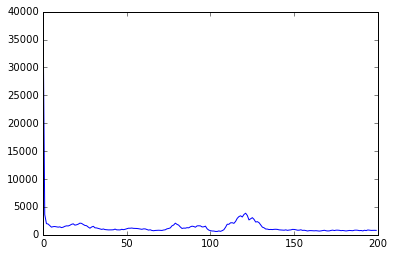

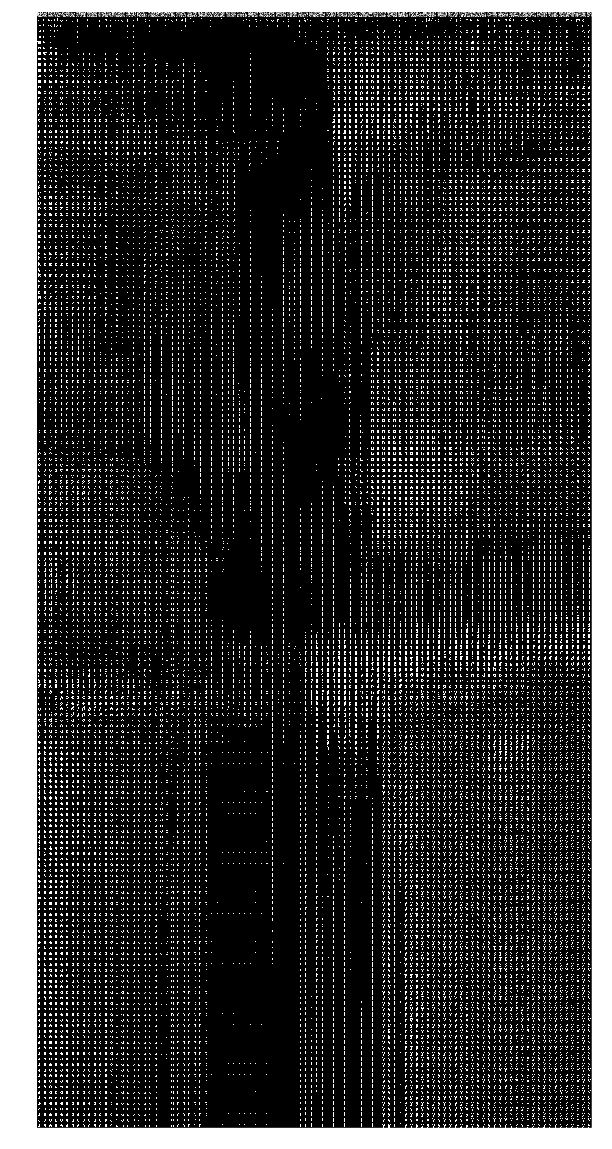

In [94]:
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave
plt.plot(loss)
print("Nb of iterations", len(loss))
fig = plt.figure(figsize=(20, 20))
if samples.shape[1] == 1:
    sz = int(np.sqrt(samples.shape[0]))
    sz = samples.shape[0]/10
    img = tile_raster_images(samples[:, 0], (w, h), (samples.shape[0]/N, N), tile_spacing=(2, 2), )
    imsave('out.png', img)
    plt.imshow(img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
else:
    ss = s.transpose((0, 2, 3, 1))
    img = dispims_color(ss)
    plt.imshow(img)
    plt.axis('off')
    plt.show()